In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Read in model data - round level (37,676)
model_data = pd.read_csv('C:\\KF_Repo\\PGA_Golf\\Tournament_level_model\\Data_manipulation\\model_data.csv')


# Group by count using pandas groupby()
grouped_data = model_data.groupby(['tournament id', 'Round'])['Round_total'].mean().reset_index()

# Rename columns
grouped_data = grouped_data.rename(columns={"tournament id": "tournament id", 
                                            "Round": "Round",
                                            "Round_total": "Avg_Score"})

# Round Avg Score to 2 decimal places (same as strokes gained)
grouped_data['Avg_Score'] = grouped_data['Avg_Score'].round(2)

# Merge dataframes by 'tournament.id' and 'Round'
add_avg = pd.merge(model_data, grouped_data, on=['tournament id', 'Round'])


# Add difference - put same format as strokes gained
# Negative is bad, positive is good
add_avg['Round_sg'] = add_avg['Avg_Score'] - add_avg['Round_total']

# Filter data for players that you want to analyze
my_players = ['Seamus Power', 'Tony Finau']
mydata2 = add_avg[add_avg['player'].isin(my_players)]

# Convert date to datetime format
mydata2['date'] = pd.to_datetime(mydata2['date'])

# Add in a column for date of round
mydata2['date_round'] = mydata2['date'] + pd.to_timedelta(mydata2['Round'] - 4, unit='D')

# Find the earliest date
earliest_date = mydata2['date_round'].min()

# Calculate the time column
mydata2['time'] = (mydata2['date_round'] - earliest_date).dt.days

# Create a sequence of unique dates and assign corresponding time values
unique_dates = mydata2['date_round'].unique()
date_to_time_mapping = pd.DataFrame({'date_round': unique_dates, 'time_2': np.arange(len(unique_dates))})

# Merge the mapping with the original dataframe
mydata2 = pd.merge(mydata2, date_to_time_mapping, on='date_round', how='left')

# Concatenate columns with "_"
unique_tr = mydata2[['tournament name','date_round', 'Round']].drop_duplicates()
unique_tr['cr'] = unique_tr['tournament name'].astype(str) + "_"+ unique_tr['date_round'].astype(str) + "_" +"R"+ unique_tr['Round'].astype(str)

# Concatenate columns with "_"
unique_tourn = mydata2[['tournament name', 'date']].drop_duplicates()
unique_tourn['tourn'] = unique_tourn['tournament name'].astype(str) + "_" + unique_tourn['date'].astype(str)

# Create additional dataframe before filter
mydata_all = pd.merge(mydata2, unique_tr, on=['tournament name','date_round', 'Round'], how='left')
mydata_all = pd.merge(mydata_all, unique_tourn, on=['tournament name', 'date'], how='left')

# Keep using mydata2
mydata2 = pd.merge(mydata2, unique_tr, on=['tournament name','date_round', 'Round'], how='left')
mydata2 = pd.merge(mydata2, unique_tourn, on=['tournament name', 'date'], how='left')


# Filter train and test data
train_data = mydata_all[mydata_all['date_round'] <= "2020-08-30"]
test_data = mydata_all[mydata_all['date_round'] > "2020-08-30"]

# Perform Regression on training data
reg_data = train_data

# Filter by player
power = reg_data[reg_data['player'] == "Seamus Power"]

# Order by date round
power = power.sort_values(by='date_round')

# Create a time series object
ts_data = pd.Series(power['Round_sg'].values, index=power['date_round'])

## partition into train and test
train_series = ts_data[:80]
test_series = ts_data[80:103]

# Build a Stan Model using a regression with different distribution

import pandas as pd
import numpy as np
import pystan
import arviz as az
import matplotlib.pyplot as plt

# Get observed scores to use for model
observed_round_score = train_series.values


C:\Users\killi\AppData\Local\Temp/ipykernel_5536/2369197793.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mydata2['date'] = pd.to_datetime(mydata2['date'])
C:\Users\killi\AppData\Local\Temp/ipykernel_5536/2369197793.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mydata2['date_round'] = mydata2['date'] + pd.to_timedelta(mydata2['Round'] - 4, unit='D')
C:\Users\killi\AppData\Local\Temp/ipykernel_5536/2369197793.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In [2]:
# Logistic model

model_code = """
data {
  int<lower=0> N; //number of rows in training set
  vector[N] y;
} 

parameters {  
  
// parameters - shape is skew - scale has to be positive
  real mu;
  real <lower=0.00001> sigma;
} 

model {
  
    // Likelihood
    y ~ logistic(mu, sigma);
}

generated quantities {
 // generate simulated values for y
  vector[N] y_sim;
  for (i in 1:N)
  y_sim[i] = logistic_rng(mu, sigma);
}


"""


model_data = {'N': len(observed_round_score),
               'y': observed_round_score}


# Create Model - this will help with recompilation issues
stan_model = pystan.StanModel(model_code=model_code)

# Call sampling function with data as argument
# Use 2 chains with 1k iterations each - 500 burn in - this will give 1k
fit = stan_model.sampling(data=model_data, iter=1000, chains=2, seed=1)

# Put Posterior draws into a dictionary
trace = fit.extract()


# Put simulations into an array
y_sim = trace['y_sim']

# Create summary dictionary
summary_dict = fit.summary()

# get trace summary
trace_summary = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])


# Print trace summary
# statistics are almos the same as statsmodel model
trace_summary

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ad14dd95b4dd4b8fdd2151c79cb88996 NOW.


,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
mu,-0.821420,0.015393,0.390468,-1.585454,-1.075361,-0.832155,-0.545176,-0.075290,643.495056,1.000867
sigma,1.939265,0.005896,0.182909,1.611072,1.811902,1.929885,2.061990,2.312408,962.493684,0.998129
y_sim[1],-0.892590,0.115438,3.709137,-8.639584,-3.135825,-0.770384,1.446102,6.295377,1032.393341,0.998730
y_sim[2],-0.804415,0.104552,3.362757,-7.658102,-2.918404,-0.647810,1.261576,5.768640,1034.497227,0.998388
y_sim[3],-0.829579,0.116193,3.595717,-7.569293,-2.936589,-0.783145,1.355816,6.552163,957.665454,1.000276
...,...,...,...,...,...,...,...,...,...,...
y_sim[77],-0.817171,0.118561,3.570093,-7.888886,-2.859352,-0.720076,1.320110,6.654168,906.724999,1.000931
y_sim[78],-0.889210,0.114978,3.515642,-8.007734,-3.023491,-0.877664,1.373734,5.978260,934.930522,0.998782
y_sim[79],-0.962486,0.106698,3.406687,-7.673522,-3.007489,-1.015269,1.227095,6.192836,1019.414639,0.999080
y_sim[80],-0.894774,0.115914,3.371597,-7.816657,-3.008491,-0.775518,1.142945,6.055624,846.064033,0.999628


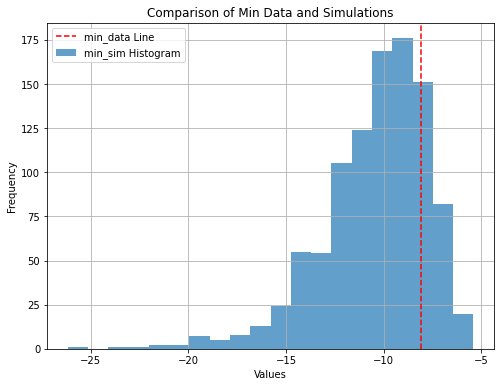

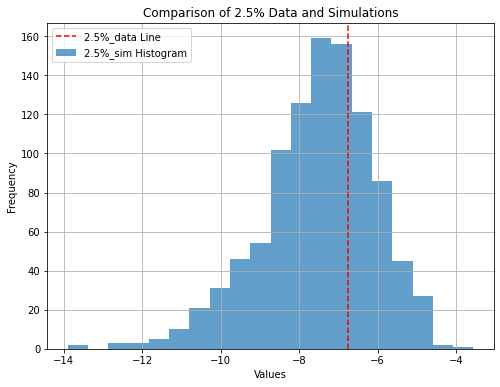

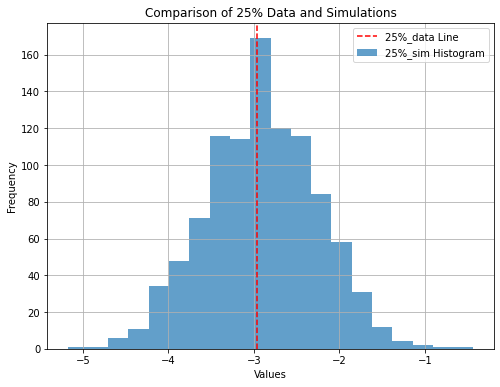

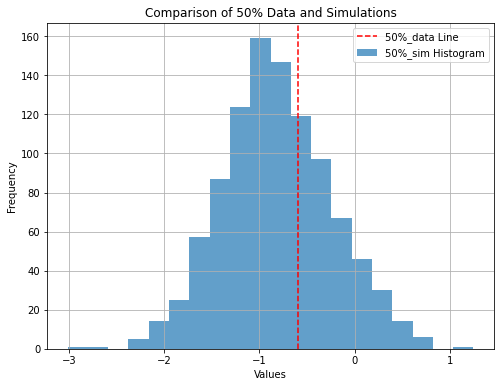

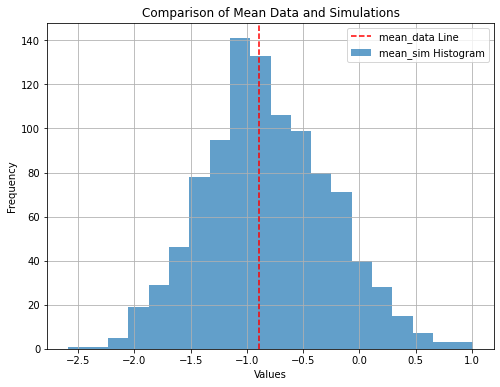

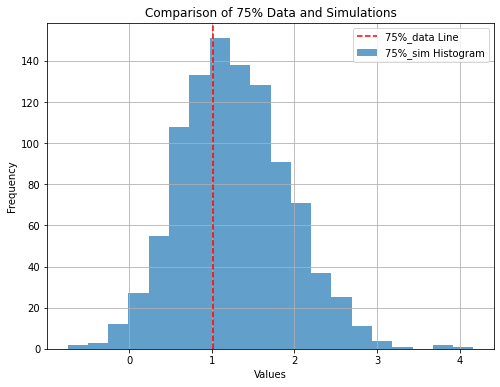

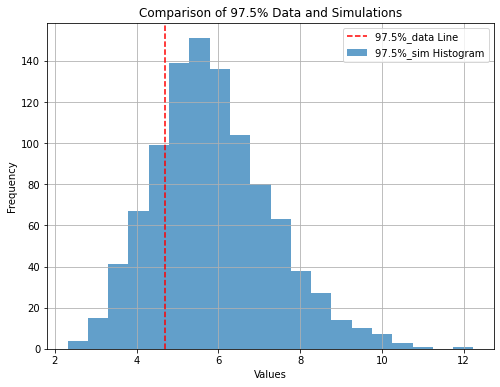

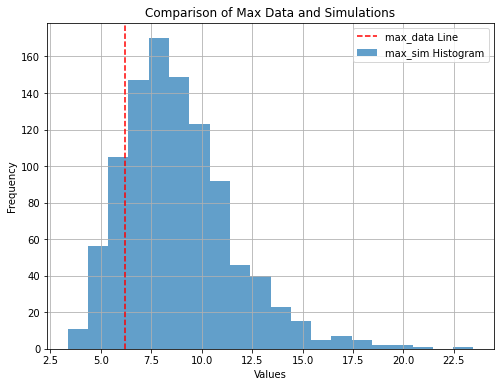

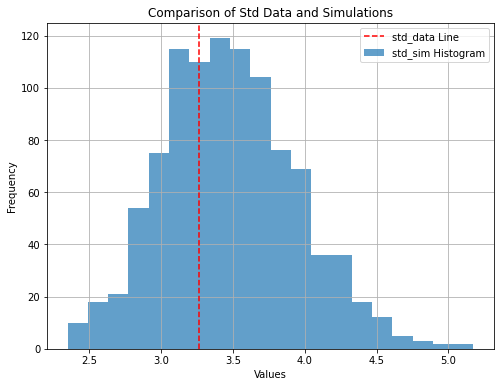

In [3]:
# Logistic - heavier tails so expecting worse

import numpy as np


# Define statistics to loop through
# Will have 1k values for each value 
# Taking the min of 80 obs 
statistics = {
    'min': (np.min(observed_round_score), np.min(y_sim, axis=1)),
    '2.5%': (np.percentile(observed_round_score,2.5),np.percentile(y_sim,2.5,axis=1)),
    '25%': (np.percentile(observed_round_score,25),np.percentile(y_sim,25,axis=1)),
    '50%': (np.percentile(observed_round_score,50),np.percentile(y_sim,50,axis=1)),
    'mean': (np.mean(observed_round_score), np.mean(y_sim, axis=1)),
    '75%': (np.percentile(observed_round_score,75),np.percentile(y_sim,75,axis=1)),
    '97.5%': (np.percentile(observed_round_score,97.5),np.percentile(y_sim,97.5,axis=1)),
    'max': (np.max(observed_round_score), np.max(y_sim, axis=1)),
    'std': (np.std(observed_round_score), np.std(y_sim, axis=1))
}

# Plotting loop
for stat_name, (data_value, sim_values) in statistics.items():
    plt.figure(figsize=(8, 6))
    plt.axvline(x=data_value, color='r', linestyle='--', label=f'{stat_name}_data Line')
    plt.hist(sim_values, bins=20, alpha=0.7, label=f'{stat_name}_sim Histogram')
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title(f'Comparison of {stat_name.capitalize()} Data and Simulations')
    plt.legend()
    plt.grid()

